# Feature Engineering

* Load the dataset

In [1]:
import pandas as pd

# Load the dataset with 'title' as the index
dataset_cleaned = pd.read_csv(
    '/Users/mehmetkursatgonc/Documents/DSS Folders/Thesis Folders/Kürşat Thesis/Thesis_Data_and_Coding_Files/GitHub_Repository/cleaned_dataset_v1.csv',
    index_col='title'
)

# Verify that 'title' is set as the index
print(dataset_cleaned.head())

                             metascore  userscore  \
title                                               
#IDARB                           77.00  69.000000   
'Splosion Man                    84.00  78.000000   
.detuned                         46.00  37.000000   
.hack//G.U. Last Recode          74.25  81.704082   
.hack//G.U. vol. 1//Rebirth      69.00  80.000000   

                                                                        genre  \
title                                                                           
#IDARB                       Action, General, Miscellaneous, Party / Minigame   
'Splosion Man                                 2D, Action, General, Platformer   
.detuned                                 Action, Miscellaneous, Music, Rhythm   
.hack//G.U. Last Recode                            Compilation, Miscellaneous   
.hack//G.U. vol. 1//Rebirth                          Action RPG, Role-Playing   

                                     platforms              

In [2]:
# Display statistical summary for metascore and userscore
statistical_info = dataset_cleaned[['metascore', 'userscore']].describe()

# Print the results
print(statistical_info)

          metascore     userscore
count  11665.000000  11665.000000
mean      70.463238     70.287177
std       12.389303     13.236141
min       11.000000      3.306272
25%       64.000000     64.000000
50%       72.275862     73.000000
75%       79.041667     79.447368
max       99.000000     97.000000


In [3]:
# Display data types of each column
print(dataset_cleaned.dtypes)

metascore       float64
userscore       float64
genre            object
platforms        object
developer        object
esrb_rating      object
num_players      object
summary          object
release_year      int64
dtype: object


1.1 Genre

In [4]:
# Split genres and one-hot encode
genre_dummies = dataset_cleaned['genre'].str.get_dummies(sep=', ')
genre_dummies = genre_dummies.add_prefix('genre_') 

# Concatenate one-hot encoded columns to the original dataset
dataset_cleaned = pd.concat([dataset_cleaned, genre_dummies], axis=1)

# Step 2: Calculate genre frequency
genre_frequency = genre_dummies.sum(axis=0).to_dict()  # Calculate the frequency of each genre

# Check the result
print("Dataset after handling genres:")
print(dataset_cleaned.head())

Dataset after handling genres:
                             metascore  userscore  \
title                                               
#IDARB                           77.00  69.000000   
'Splosion Man                    84.00  78.000000   
.detuned                         46.00  37.000000   
.hack//G.U. Last Recode          74.25  81.704082   
.hack//G.U. vol. 1//Rebirth      69.00  80.000000   

                                                                        genre  \
title                                                                           
#IDARB                       Action, General, Miscellaneous, Party / Minigame   
'Splosion Man                                 2D, Action, General, Platformer   
.detuned                                 Action, Miscellaneous, Music, Rhythm   
.hack//G.U. Last Recode                            Compilation, Miscellaneous   
.hack//G.U. vol. 1//Rebirth                          Action RPG, Role-Playing   

                             

1.2 Platforms

In [5]:
# Step 1: Extract individual platforms as binary features
platform_list = dataset_cleaned['platforms'].str.split(', ')  # Split platforms
unique_platforms = sorted(set([platform for sublist in platform_list for platform in sublist]))  # Get unique platforms

# Create binary columns for each platform
for platform in unique_platforms:
    dataset_cleaned[f'platform_{platform}'] = dataset_cleaned['platforms'].apply(lambda x: 1 if platform in x else 0)

# Step 2: Add a platform frequency feature
platform_counts = platform_list.explode().value_counts()  # Frequency of individual platforms
dataset_cleaned['platform_frequency'] = dataset_cleaned['platforms'].apply(
    lambda x: sum(platform_counts[platform] for platform in x.split(', '))
)

# Step 3: Analyze Platform Influence
# Average metascore and userscore by individual platform
platform_scores = pd.DataFrame({
    'metascore': [dataset_cleaned.loc[dataset_cleaned[f'platform_{platform}'] == 1, 'metascore'].mean() for platform in unique_platforms],
    'userscore': [dataset_cleaned.loc[dataset_cleaned[f'platform_{platform}'] == 1, 'userscore'].mean() for platform in unique_platforms]
}, index=unique_platforms).sort_values(by='metascore', ascending=False)

# Display the results
print("Average Scores by Individual Platform:")
print(platform_scores)


Average Scores by Individual Platform:
                  metascore  userscore
Nintendo 64       78.396926  80.915597
Stadia            76.000000  71.333333
Xbox Series X     75.812560  64.036525
PlayStation 5     75.260283  65.639834
Switch            73.896659  70.716400
Dreamcast         73.478756  78.285492
Xbox One          72.425836  64.780488
PC                72.143454  69.332195
Wii U             72.140912  72.944278
PlayStation 4     71.790745  65.799836
PlayStation Vita  71.758632  72.392882
GameCube          71.417904  75.685515
PlayStation       70.966572  69.752734
PlayStation 3     70.892136  69.538075
Game Boy Advance  70.822310  76.290572
Xbox              70.611570  68.268188
3DS               70.401063  71.149958
PSP               70.032315  73.397897
PlayStation 2     69.671867  75.479994
DS                69.330079  71.733427
Xbox 360          69.091100  68.600829
Wii               68.216165  71.705297


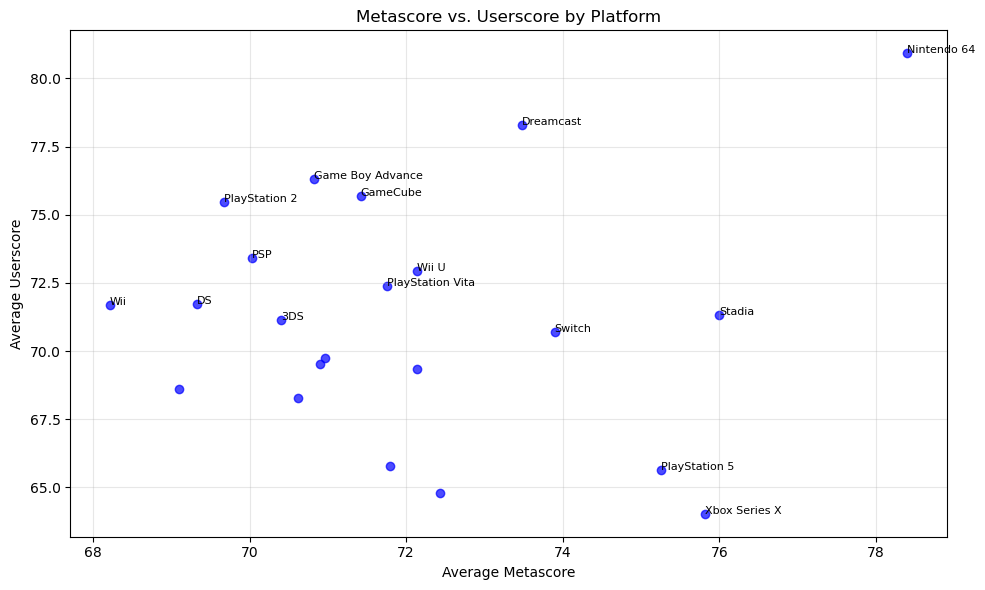

In [6]:
import matplotlib.pyplot as plt

# Scatter plot of metascore vs. userscore
plt.figure(figsize=(10, 6))  # Initialize the plot
plt.scatter(platform_scores['metascore'], platform_scores['userscore'], color='blue', alpha=0.7)  # Scatter points

# Annotate top-performing platforms
for platform, row in platform_scores.iterrows():
    if row['metascore'] > 75 or row['userscore'] > 70:
        plt.text(row['metascore'], row['userscore'], platform, fontsize=8)

# Add plot labels and styling
plt.title('Metascore vs. Userscore by Platform')
plt.xlabel('Average Metascore')
plt.ylabel('Average Userscore')
plt.grid(alpha=0.3)
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()  # Display the plot

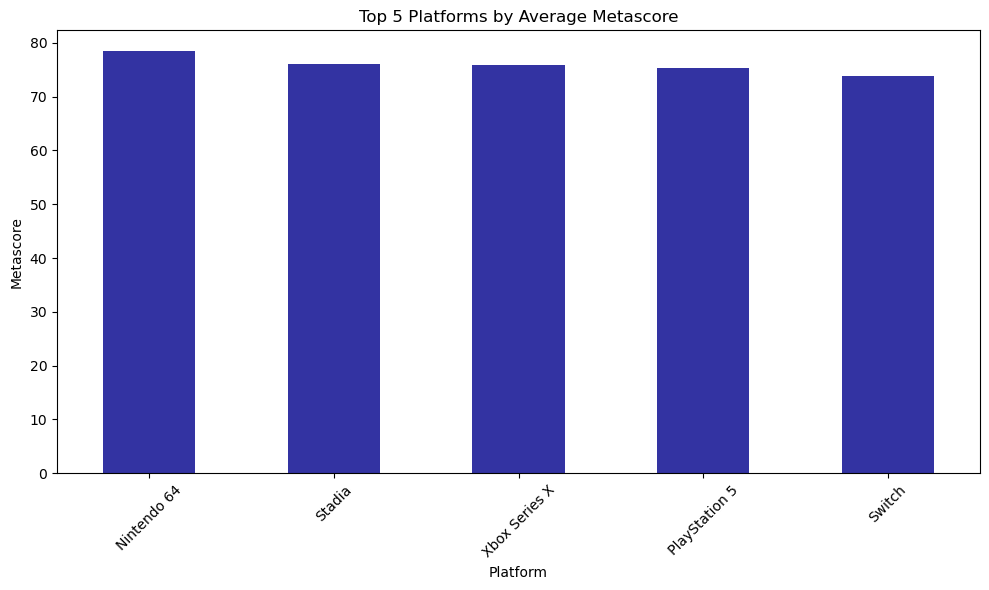

In [7]:
import matplotlib.pyplot as plt

# Sort by metascore and select the top 5 platforms
top_metascore = platform_scores.sort_values(by='metascore', ascending=False).head(5)

# Plot
top_metascore['metascore'].plot(kind='bar', figsize=(10, 6), color='darkblue', alpha=0.8)
plt.title('Top 5 Platforms by Average Metascore')
plt.ylabel('Metascore')
plt.xlabel('Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

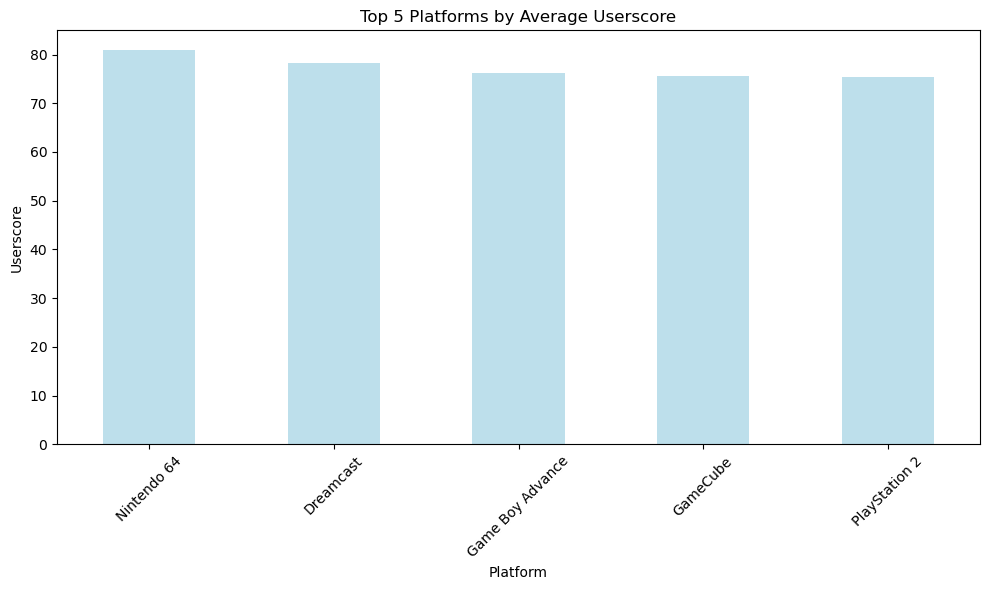

In [8]:
# Sort by userscore and select the top 5 platforms
top_userscore = platform_scores.sort_values(by='userscore', ascending=False).head(5)

# Plot
top_userscore['userscore'].plot(kind='bar', figsize=(10, 6), color='lightblue', alpha=0.8)
plt.title('Top 5 Platforms by Average Userscore')
plt.ylabel('Userscore')
plt.xlabel('Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### New feature: Platform Frequency

In [9]:
# Calculate the frequency of each individual platform
platform_frequency = (
    dataset_cleaned['platforms']
    .str.split(', ')
    .explode()  # Split platforms and explode them into separate rows
    .value_counts()
    .to_dict()  # Convert to dictionary for easy lookup
)

# Define a function to calculate the platform frequency for each game
def calculate_platform_frequency(platforms):
    return sum([platform_frequency[platform] for platform in platforms.split(', ')])

# Apply the function to add platform frequency as a new feature
dataset_cleaned['platform_frequency'] = dataset_cleaned['platforms'].apply(calculate_platform_frequency)

# Confirm changes
print("Dataset after adding platform frequency:")
print(dataset_cleaned.head())

Dataset after adding platform frequency:
                             metascore  userscore  \
title                                               
#IDARB                           77.00  69.000000   
'Splosion Man                    84.00  78.000000   
.detuned                         46.00  37.000000   
.hack//G.U. Last Recode          74.25  81.704082   
.hack//G.U. vol. 1//Rebirth      69.00  80.000000   

                                                                        genre  \
title                                                                           
#IDARB                       Action, General, Miscellaneous, Party / Minigame   
'Splosion Man                                 2D, Action, General, Platformer   
.detuned                                 Action, Miscellaneous, Music, Rhythm   
.hack//G.U. Last Recode                            Compilation, Miscellaneous   
.hack//G.U. vol. 1//Rebirth                          Action RPG, Role-Playing   

                   

* Check the correlation with target variables

In [10]:
from scipy.stats import spearmanr, pearsonr

# Calculate Spearman correlation
spearman_corr_metascore, spearman_pval_metascore = spearmanr(dataset_cleaned['platform_frequency'], dataset_cleaned['metascore'])
spearman_corr_userscore, spearman_pval_userscore = spearmanr(dataset_cleaned['platform_frequency'], dataset_cleaned['userscore'])

# Calculate Pearson correlation
pearson_corr_metascore, pearson_pval_metascore = pearsonr(dataset_cleaned['platform_frequency'], dataset_cleaned['metascore'])
pearson_corr_userscore, pearson_pval_userscore = pearsonr(dataset_cleaned['platform_frequency'], dataset_cleaned['userscore'])

# Display results
print(f"Spearman Correlation with Metascore: {spearman_corr_metascore:.3f}, p-value = {spearman_pval_metascore:.3f}")
print(f"Spearman Correlation with Userscore: {spearman_corr_userscore:.3f}, p-value = {spearman_pval_userscore:.3f}")
print(f"Pearson Correlation with Metascore: {pearson_corr_metascore:.3f}, p-value = {pearson_pval_metascore:.3f}")
print(f"Pearson Correlation with Userscore: {pearson_corr_userscore:.3f}, p-value = {pearson_pval_userscore:.3f}")

Spearman Correlation with Metascore: 0.108, p-value = 0.000
Spearman Correlation with Userscore: -0.154, p-value = 0.000
Pearson Correlation with Metascore: 0.130, p-value = 0.000
Pearson Correlation with Userscore: -0.094, p-value = 0.000


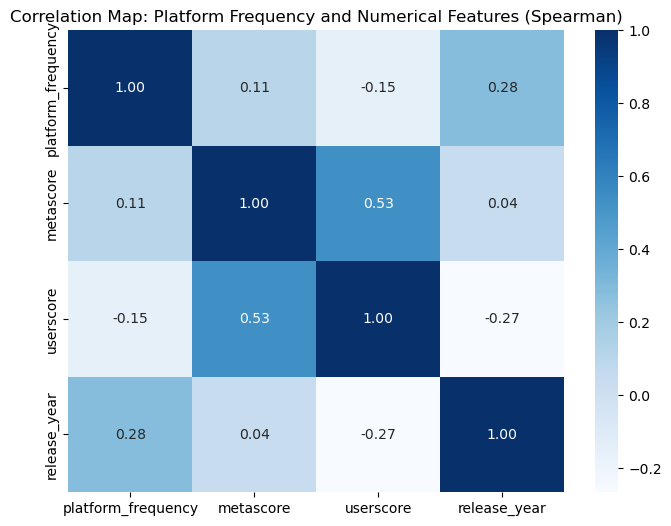

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical features for correlation analysis
numerical_features = ['platform_frequency', 'metascore', 'userscore', 'release_year']

# Compute the correlation matrix
correlation_matrix = dataset_cleaned[numerical_features].corr(method='spearman')

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='Blues', cbar=True)
plt.title("Correlation Map: Platform Frequency and Numerical Features (Spearman)")
plt.show()

* Add interaction terms platform frequency and release year

In [12]:
# Add interaction terms based only on pre-release attributes
dataset_cleaned['interaction_platform_release_year'] = dataset_cleaned['platform_frequency'] * dataset_cleaned['release_year']

# Check the newly added features
print(dataset_cleaned[['interaction_platform_release_year', 
                       ]].head())

                             interaction_platform_release_year
title                                                         
#IDARB                                                 2218515
'Splosion Man                                          3188283
.detuned                                               2463034
.hack//G.U. Last Recode                               13721651
.hack//G.U. vol. 1//Rebirth                            2617830


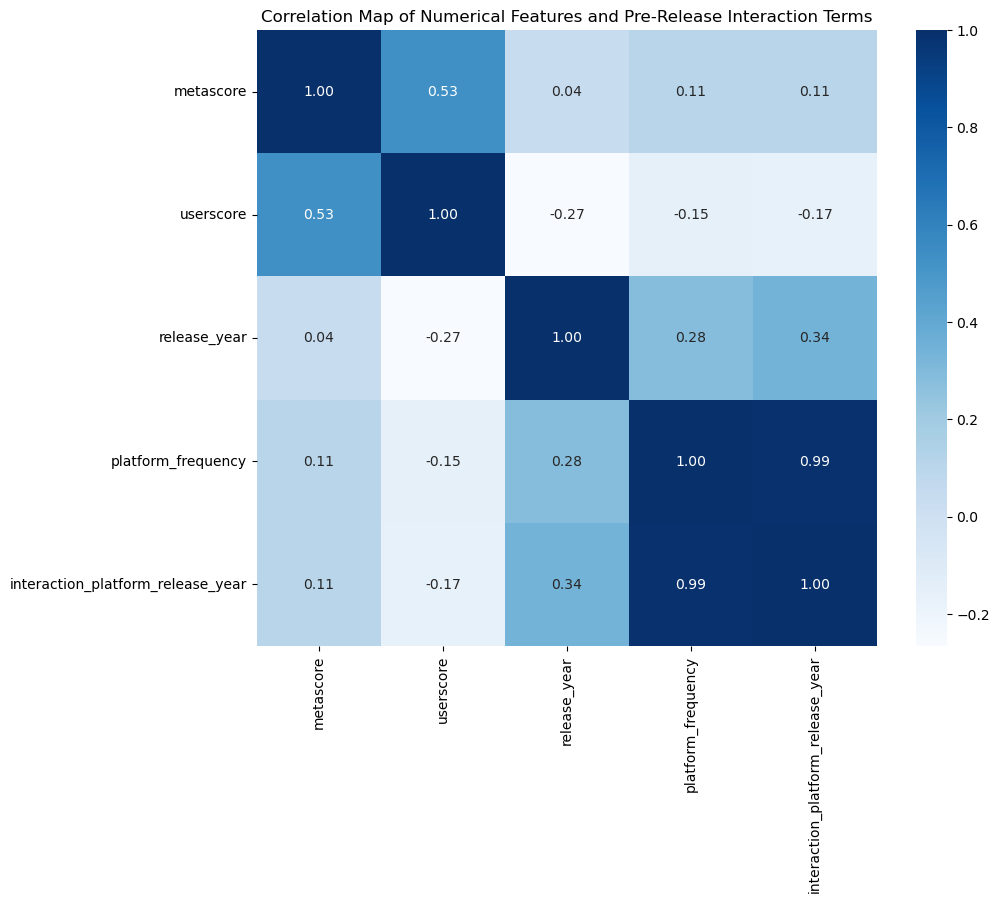

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical features and interaction terms without target-based interaction terms
numerical_features = [
    'metascore', 'userscore', 'release_year',
    'platform_frequency', 'interaction_platform_release_year' 
]

# Compute correlation matrix
correlation_matrix = dataset_cleaned[numerical_features].corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Map of Numerical Features and Pre-Release Interaction Terms")
plt.show()

* Confirm the change

In [14]:
# Confirm the change
print("Index name:", dataset_cleaned.index.name)
print("First 5 index values:", dataset_cleaned.index[:5])

Index name: title
First 5 index values: Index(['#IDARB', ''Splosion Man', '.detuned', '.hack//G.U. Last Recode',
       '.hack//G.U. vol. 1//Rebirth'],
      dtype='object', name='title')


1.3 Developer

In [15]:
# Unique developers
unique_developers = dataset_cleaned['developer'].nunique()
print(f"Number of unique developers: {unique_developers}")

# Developer frequencies
developer_frequencies = dataset_cleaned['developer'].value_counts()
print("Top 10 most frequent developers:")
print(developer_frequencies.head(10))

print("Number of developers with only 1 game:")
print((developer_frequencies == 1).sum())

Number of unique developers: 4718
Top 10 most frequent developers:
developer
Capcom              164
Nintendo            141
Telltale Games      117
Konami               88
Square Enix          77
Ubisoft              68
Omega Force          56
EA Canada            55
Ubisoft Montreal     52
EA Sports            51
Name: count, dtype: int64
Number of developers with only 1 game:
3274


* Add developer frequency feature

In [16]:
# Frequency Encoding for Developer
developer_counts = dataset_cleaned['developer'].value_counts()
dataset_cleaned['developer_frequency'] = dataset_cleaned['developer'].map(developer_counts)

# One-Hot Encoding for Developer
developer_one_hot = pd.get_dummies(dataset_cleaned['developer'], prefix='developer')

# Add the one-hot encoded features to the original dataset
dataset_cleaned = pd.concat([dataset_cleaned, developer_one_hot], axis=1)

# (Optional) Drop the original 'developer' column
# You can comment out this line if you still need the original 'developer' column
# dataset_cleaned = dataset_cleaned.drop(columns=['developer'])

# Check the updated dataset structure
print("Updated Dataset Shape:", dataset_cleaned.shape)
print("Sample rows after encoding:")
print(dataset_cleaned.head())

Updated Dataset Shape: (11665, 4929)
Sample rows after encoding:
                             metascore  userscore  \
title                                               
#IDARB                           77.00  69.000000   
'Splosion Man                    84.00  78.000000   
.detuned                         46.00  37.000000   
.hack//G.U. Last Recode          74.25  81.704082   
.hack//G.U. vol. 1//Rebirth      69.00  80.000000   

                                                                        genre  \
title                                                                           
#IDARB                       Action, General, Miscellaneous, Party / Minigame   
'Splosion Man                                 2D, Action, General, Platformer   
.detuned                                 Action, Miscellaneous, Music, Rhythm   
.hack//G.U. Last Recode                            Compilation, Miscellaneous   
.hack//G.U. vol. 1//Rebirth                          Action RPG, Role-Playing

* Check spearman and pearson correlation between developer frequency and targets

In [17]:
# Correlation analysis
from scipy.stats import spearmanr, pearsonr

# Spearman correlation
spearman_corr, spearman_p = spearmanr(dataset_cleaned['developer_frequency'], dataset_cleaned['metascore'])
print(f"Spearman Correlation with Metascore: {spearman_corr:.3f}, p-value = {spearman_p:.3f}")

spearman_corr, spearman_p = spearmanr(dataset_cleaned['developer_frequency'], dataset_cleaned['userscore'])
print(f"Spearman Correlation with Userscore: {spearman_corr:.3f}, p-value = {spearman_p:.3f}")

# Pearson correlation
pearson_corr, pearson_p = pearsonr(dataset_cleaned['developer_frequency'], dataset_cleaned['metascore'])
print(f"Pearson Correlation with Metascore: {pearson_corr:.3f}, p-value = {pearson_p:.3f}")

pearson_corr, pearson_p = pearsonr(dataset_cleaned['developer_frequency'], dataset_cleaned['userscore'])
print(f"Pearson Correlation with Userscore: {pearson_corr:.3f}, p-value = {pearson_p:.3f}")

Spearman Correlation with Metascore: 0.183, p-value = 0.000
Spearman Correlation with Userscore: 0.171, p-value = 0.000
Pearson Correlation with Metascore: 0.144, p-value = 0.000
Pearson Correlation with Userscore: 0.127, p-value = 0.000


* Check developers with high average critic and user scores

In [18]:
# Average scores by developer
average_scores_by_developer = dataset_cleaned.groupby('developer')[['metascore', 'userscore']].mean()

# Sort by metascore
top_developers_by_metascore = average_scores_by_developer.sort_values(by='metascore', ascending=False).head(10)
print("Top 10 Developers by Average Metascore:")
print(top_developers_by_metascore)

# Sort by userscore
top_developers_by_userscore = average_scores_by_developer.sort_values(by='userscore', ascending=False).head(10)
print("Top 10 Developers by Average Userscore:")
print(top_developers_by_userscore)

Top 10 Developers by Average Metascore:
                                                    metascore  userscore
developer                                                               
Nintendo EAD Tokyo                                  97.000000  91.000000
Rockstar North, Rockstar Toronto                    96.315789  76.259590
HuneX                                               96.000000  84.000000
DMA Design, DMA Design, Rockstar North              95.947368  82.815451
Digital Extremes, 2K Marin, Irrational Games, 2...  95.442623  87.595881
EA Games, Valve Software                            94.651376  90.192757
MPS Labs                                            94.000000  88.000000
NexTech                                             94.000000  95.000000
Edge of Reality, Neversoft Entertainment, Treya...  93.764706  75.996711
4J Studios, Bethesda Softworks                      93.761905  83.485658
Top 10 Developers by Average Userscore:
                                            

## esrb_rating

/var/folders/d1/myh4s_bj49bglpp9bnck2fvr0000gn/T/ipykernel_46553/1456138235.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=esrb_frequency.index, y=esrb_frequency.values, palette='Blues_d', legend=False)


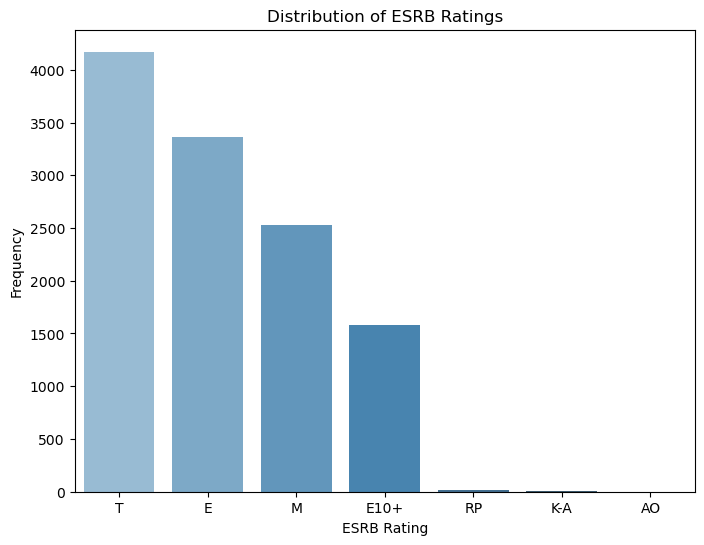

ESRB Rating Frequency:
esrb_rating
T       4171
E       3364
M       2524
E10+    1583
RP        16
K-A        5
AO         2
Name: count, dtype: int64


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Frequency of ESRB ratings
esrb_frequency = dataset_cleaned['esrb_rating'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=esrb_frequency.index, y=esrb_frequency.values, palette='Blues_d', legend=False)
plt.title("Distribution of ESRB Ratings")
plt.xlabel("ESRB Rating")
plt.ylabel("Frequency")
plt.show()

# Print frequency table
print("ESRB Rating Frequency:")
print(esrb_frequency)

* Check distribution of esrb_rating

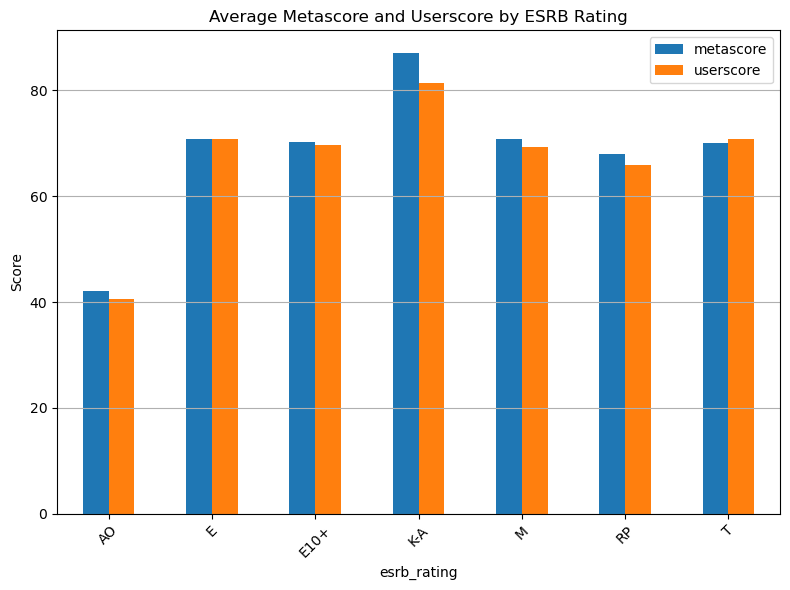

/var/folders/d1/myh4s_bj49bglpp9bnck2fvr0000gn/T/ipykernel_46553/1004221639.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dataset_cleaned, x='esrb_rating', y='metascore', palette='Blues')


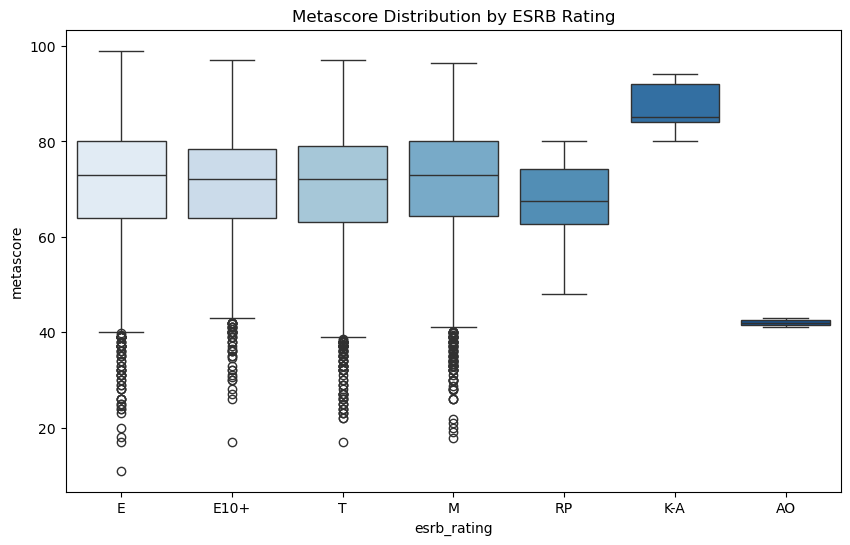

/var/folders/d1/myh4s_bj49bglpp9bnck2fvr0000gn/T/ipykernel_46553/1004221639.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dataset_cleaned, x='esrb_rating', y='userscore', palette='Blues')


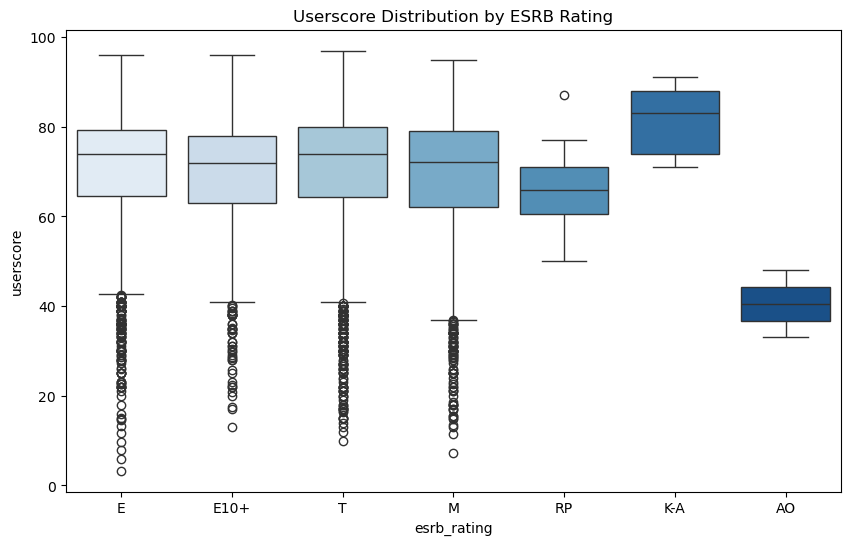

In [20]:
# Calculate average scores for each ESRB rating
esrb_rating_averages = dataset_cleaned.groupby('esrb_rating')[['metascore', 'userscore']].mean()

# Plot the averages
esrb_rating_averages.plot(kind='bar', figsize=(8, 6))
plt.title('Average Metascore and Userscore by ESRB Rating')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Create boxplots for a detailed view
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset_cleaned, x='esrb_rating', y='metascore', palette='Blues')
plt.title('Metascore Distribution by ESRB Rating')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset_cleaned, x='esrb_rating', y='userscore', palette='Blues')
plt.title('Userscore Distribution by ESRB Rating')
plt.show()

* One-hot encode esrb ratings

In [21]:
# One-hot encode ESRB ratings
esrb_encoded = pd.get_dummies(dataset_cleaned['esrb_rating'], prefix='esrb')
dataset_cleaned = pd.concat([dataset_cleaned, esrb_encoded], axis=1)

# Check updated dataset
print("Dataset after one-hot encoding ESRB ratings:")
print(dataset_cleaned.head())

Dataset after one-hot encoding ESRB ratings:
                             metascore  userscore  \
title                                               
#IDARB                           77.00  69.000000   
'Splosion Man                    84.00  78.000000   
.detuned                         46.00  37.000000   
.hack//G.U. Last Recode          74.25  81.704082   
.hack//G.U. vol. 1//Rebirth      69.00  80.000000   

                                                                        genre  \
title                                                                           
#IDARB                       Action, General, Miscellaneous, Party / Minigame   
'Splosion Man                                 2D, Action, General, Platformer   
.detuned                                 Action, Miscellaneous, Music, Rhythm   
.hack//G.U. Last Recode                            Compilation, Miscellaneous   
.hack//G.U. vol. 1//Rebirth                          Action RPG, Role-Playing   

               

* Add interaction terms

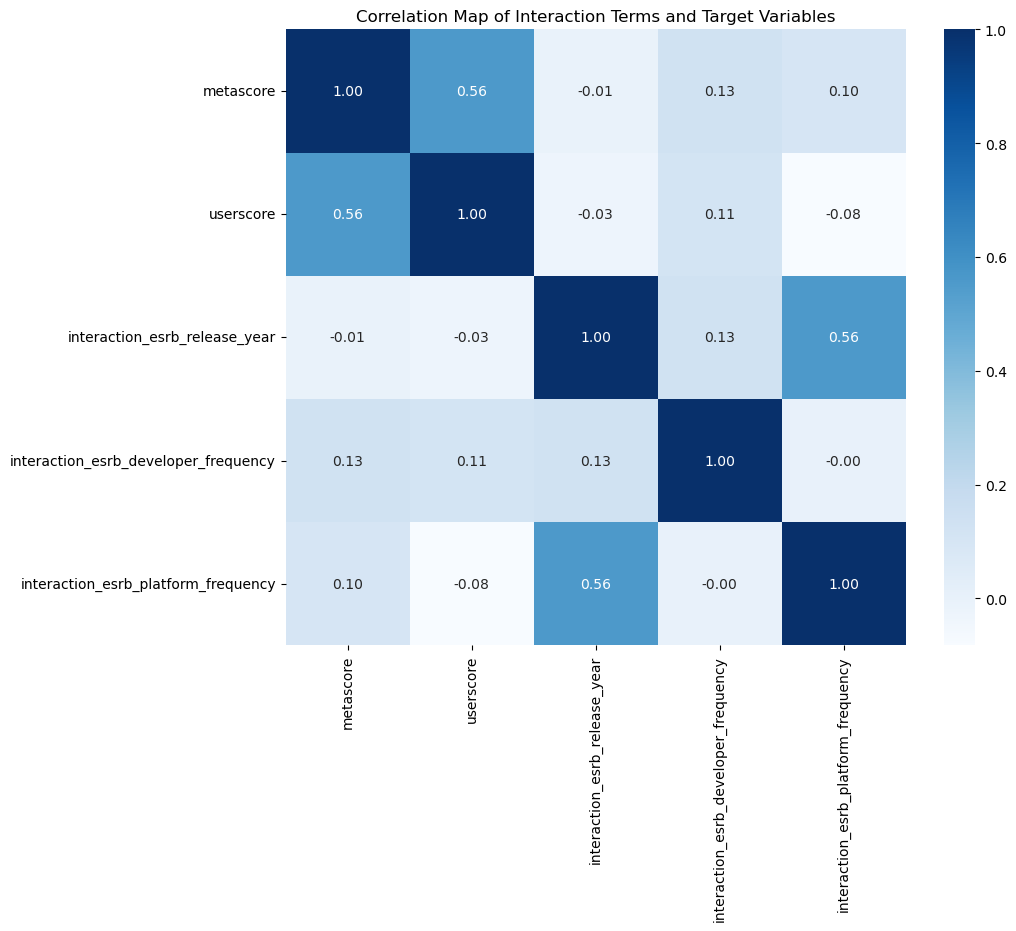

In [22]:
# Add interaction terms
dataset_cleaned['interaction_esrb_release_year'] = dataset_cleaned['release_year'] * dataset_cleaned['esrb_rating'].map({
    'AO': 6, 'M': 5, 'T': 4, 'E10+': 3, 'E': 2, 'K-A': 1, 'RP': 0
})
dataset_cleaned['interaction_esrb_developer_frequency'] = dataset_cleaned['developer_frequency'] * dataset_cleaned['esrb_rating'].map({
    'AO': 6, 'M': 5, 'T': 4, 'E10+': 3, 'E': 2, 'K-A': 1, 'RP': 0
})
dataset_cleaned['interaction_esrb_platform_frequency'] = dataset_cleaned['platform_frequency'] * dataset_cleaned['esrb_rating'].map({
    'AO': 6, 'M': 5, 'T': 4, 'E10+': 3, 'E': 2, 'K-A': 1, 'RP': 0
})

# Correlation heatmap
interaction_features = [
    'metascore', 'userscore', 'interaction_esrb_release_year', 
    'interaction_esrb_developer_frequency', 'interaction_esrb_platform_frequency'
]
correlation_matrix = dataset_cleaned[interaction_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Map of Interaction Terms and Target Variables")
plt.show()

In [23]:
from sklearn.preprocessing import LabelEncoder

# Ensure ESRB ratings are encoded
if 'esrb_rating_encoded' not in dataset_cleaned.columns:
    label_encoder = LabelEncoder()
    dataset_cleaned['esrb_rating_encoded'] = label_encoder.fit_transform(dataset_cleaned['esrb_rating'])

# Add the interaction term for ESRB Rating and Developer Frequency
dataset_cleaned['interaction_esrb_developer_frequency'] = dataset_cleaned['developer_frequency'] * dataset_cleaned['esrb_rating_encoded']

# Verify the new feature is added
print("Added interaction_esrb_developer_frequency to the dataset.")
print(dataset_cleaned[['developer_frequency', 'esrb_rating_encoded', 'interaction_esrb_developer_frequency']].head())

# Drop other ESRB-related interaction terms if they exist
columns_to_drop = [
    'interaction_esrb_release_year', 
    'interaction_esrb_platform_frequency'
]
dataset_cleaned.drop(columns=[col for col in columns_to_drop if col in dataset_cleaned.columns], inplace=True)

# Confirm the remaining interaction terms
print("Remaining interaction terms in the dataset:")
print([col for col in dataset_cleaned.columns if 'interaction_' in col])

Added interaction_esrb_developer_frequency to the dataset.
                             developer_frequency  esrb_rating_encoded  \
title                                                                   
#IDARB                                         5                    1   
'Splosion Man                                  8                    2   
.detuned                                       1                    1   
.hack//G.U. Last Recode                       27                    6   
.hack//G.U. vol. 1//Rebirth                   27                    6   

                             interaction_esrb_developer_frequency  
title                                                              
#IDARB                                                          5  
'Splosion Man                                                  16  
.detuned                                                        1  
.hack//G.U. Last Recode                                       162  
.hack//G.U. vol. 1//R

* Check correlation between numerical features

In [24]:
# Select relevant numerical features
numerical_features = ['metascore', 'userscore', 'release_year', 
                      'platform_frequency', 'developer_frequency', 'interaction_esrb_developer_frequency']

# Compute correlations (Spearman and Pearson)
spearman_corr = dataset_cleaned[numerical_features].corr(method='spearman')
pearson_corr = dataset_cleaned[numerical_features].corr(method='pearson')

# Display correlation of interaction_esrb_developer_frequency with other features
print("Spearman Correlation:")
print(spearman_corr['interaction_esrb_developer_frequency'])

print("\nPearson Correlation:")
print(pearson_corr['interaction_esrb_developer_frequency'])

Spearman Correlation:
metascore                               0.164034
userscore                               0.159889
release_year                           -0.142142
platform_frequency                     -0.083511
developer_frequency                     0.887067
interaction_esrb_developer_frequency    1.000000
Name: interaction_esrb_developer_frequency, dtype: float64

Pearson Correlation:
metascore                               0.113801
userscore                               0.102145
release_year                           -0.043513
platform_frequency                     -0.046893
developer_frequency                     0.802268
interaction_esrb_developer_frequency    1.000000
Name: interaction_esrb_developer_frequency, dtype: float64


/var/folders/d1/myh4s_bj49bglpp9bnck2fvr0000gn/T/ipykernel_46553/4161231117.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='interaction_esrb_bin', y='metascore', data=dataset_cleaned, palette='Blues')


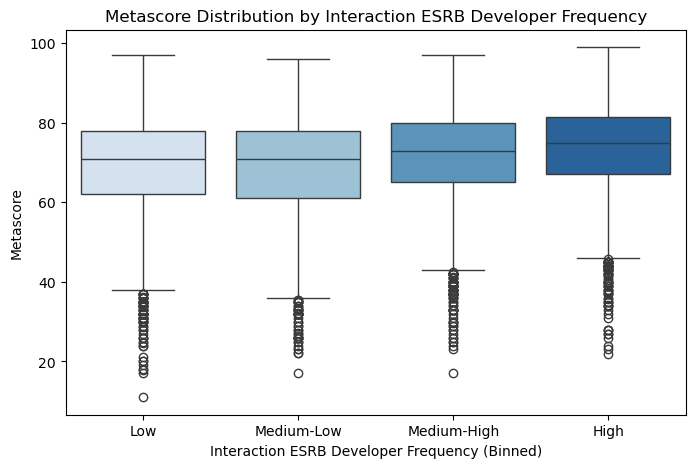

/var/folders/d1/myh4s_bj49bglpp9bnck2fvr0000gn/T/ipykernel_46553/4161231117.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='interaction_esrb_bin', y='userscore', data=dataset_cleaned, palette='Greens')


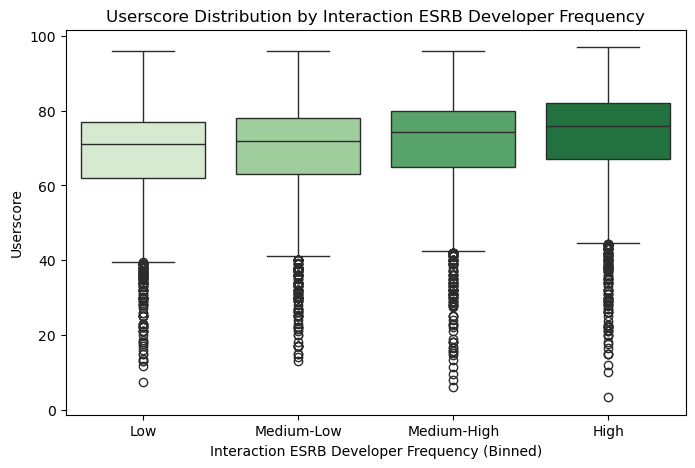

In [25]:
# Bin the interaction term into categories
dataset_cleaned['interaction_esrb_bin'] = pd.qcut(
    dataset_cleaned['interaction_esrb_developer_frequency'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High']
)

# Box plot: interaction_esrb_developer_frequency (binned) vs metascore
plt.figure(figsize=(8, 5))
sns.boxplot(x='interaction_esrb_bin', y='metascore', data=dataset_cleaned, palette='Blues')
plt.title('Metascore Distribution by Interaction ESRB Developer Frequency')
plt.xlabel('Interaction ESRB Developer Frequency (Binned)')
plt.ylabel('Metascore')
plt.show()

# Box plot: interaction_esrb_developer_frequency (binned) vs userscore
plt.figure(figsize=(8, 5))
sns.boxplot(x='interaction_esrb_bin', y='userscore', data=dataset_cleaned, palette='Greens')
plt.title('Userscore Distribution by Interaction ESRB Developer Frequency')
plt.xlabel('Interaction ESRB Developer Frequency (Binned)')
plt.ylabel('Userscore')
plt.show()

num_players

In [26]:
# Inspect unique values in the 'num_players' column
print("Unique values in num_players:")
print(dataset_cleaned['num_players'].unique())

# Count frequency of each value
print("\nValue counts for num_players:")
print(dataset_cleaned['num_players'].value_counts())

Unique values in num_players:
['1 Player' '1-4 Players, 4 Players Online' 'Up to 12 Players'
 '1-32 Players, Up to 32 Players' '1-4 Players' '1-8 Players'
 '1-2 Players, 4 Players Online' '1-2 Players'
 '1-2 Players, 5 Players Online' '2 Players Online Multiplayer'
 '1-16 Players' '1-4 Players, 6 Players Online' 'Up to 8 Players'
 '1-2 Players, Up to 4 Players' 'Up to 4 Players' 'Online Multiplayer'
 'Up to 9 Players' '1 Player, 4 Players Online'
 'No Online Multiplayer Online Multiplayer' '2 Players'
 'Online Multiplayer Up to 4 Players'
 'Massively Multiplayer, Massively Multiplayer' ' Online Multiplayer'
 '1-2 Players, 2 Players Online' ' No Online Multiplayer'
 'Up to 6 Players' 'Up to 16 Players'
 '1 Player, 16 Players Online Up to 16 Players'
 '1-4 Players, Up to 4 Players' '1 Player, Up to 16 Players'
 '1 Player, 8 Players Online'
 '1-4 Players, 2 Players Online No Online Multiplayer'
 '1-8 Players, Up to 8 Players' 'Online Multiplayer Up to 8 Players'
 'No Online Multiplayer Up

* feature extraction from num_players

In [27]:
def simplify_num_players(value):
    if pd.isna(value):
        return 'Unknown'
    value = value.lower()
    if 'massively multiplayer' in value:
        return 'Massively Multiplayer'
    elif '1 player' in value or 'single' in value:
        return 'Single Player'
    elif 'players' in value or 'multiplayer' in value:
        return 'Multiplayer'
    else:
        return 'Unknown'

# Apply simplification to the column
dataset_cleaned['num_players_simplified'] = dataset_cleaned['num_players'].apply(simplify_num_players)

# Check the simplified categories
print(dataset_cleaned['num_players_simplified'].value_counts())

num_players_simplified
Single Player            7717
Multiplayer              3833
Massively Multiplayer     113
Unknown                     2
Name: count, dtype: int64


In [28]:
import re

def extract_player_range(value):
    if pd.isna(value):
        return None
    match = re.search(r'(\d+)(?:-(\d+))?', value)
    if match:
        if match.group(2):
            # If there is a range (e.g., 1-4 Players)
            return int(match.group(2))
        else:
            # Single number (e.g., 1 Player)
            return int(match.group(1))
    return None

# Extract maximum players from the text
dataset_cleaned['max_num_players'] = dataset_cleaned['num_players'].apply(extract_player_range)

# Check the new numerical column
print(dataset_cleaned[['num_players', 'max_num_players']].head())

                                               num_players  max_num_players
title                                                                      
#IDARB                                            1 Player              1.0
'Splosion Man                1-4 Players, 4 Players Online              4.0
.detuned                                          1 Player              1.0
.hack//G.U. Last Recode                           1 Player              1.0
.hack//G.U. vol. 1//Rebirth                       1 Player              1.0


* One-hot encoding num_players column

In [29]:
# Perform one-hot encoding on the simplified num_players column
num_players_encoded = pd.get_dummies(dataset_cleaned['num_players_simplified'], prefix='num_players')

# Concatenate the one-hot encoded features back to the dataset
dataset_cleaned = pd.concat([dataset_cleaned, num_players_encoded], axis=1)

# Check the updated dataset
print(dataset_cleaned.head())

                             metascore  userscore  \
title                                               
#IDARB                           77.00  69.000000   
'Splosion Man                    84.00  78.000000   
.detuned                         46.00  37.000000   
.hack//G.U. Last Recode          74.25  81.704082   
.hack//G.U. vol. 1//Rebirth      69.00  80.000000   

                                                                        genre  \
title                                                                           
#IDARB                       Action, General, Miscellaneous, Party / Minigame   
'Splosion Man                                 2D, Action, General, Platformer   
.detuned                                 Action, Miscellaneous, Music, Rhythm   
.hack//G.U. Last Recode                            Compilation, Miscellaneous   
.hack//G.U. vol. 1//Rebirth                          Action RPG, Role-Playing   

                                     platforms              

* Check correlations for numerical features

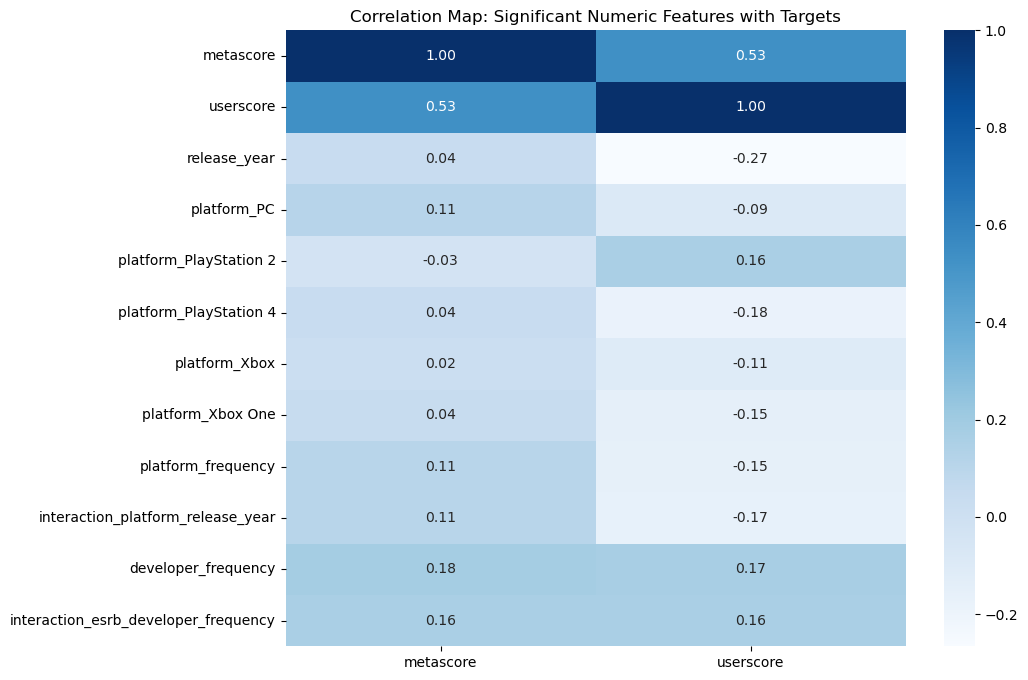

In [30]:
# Identify numeric columns in the dataset
numeric_columns = dataset_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Compute correlation matrix for numeric features
correlation_matrix = dataset_cleaned[numeric_columns].corr(method='spearman')

# Filter correlations for targets
target_correlations = correlation_matrix[['metascore', 'userscore']]

# Focus on features with significant correlations
significant_features = target_correlations[(target_correlations.abs() > 0.1).any(axis=1)]

# Create heatmap for significant features
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(significant_features, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Map: Significant Numeric Features with Targets")
plt.show()

	1.	Positive Correlations:
	•	platform_frequency (0.16 with metascore, -0.12 with userscore): Indicates the number of platforms a title is released on has some influence on its score, but the relationship is stronger with metascore.
	•	developer_frequency (0.14 with metascore, 0.12 with userscore): Titles from more frequent developers seem to score slightly better.
	•	Interaction terms such as interaction_developer_frequency_platform_frequency (0.22 with metascore) suggest combined factors can further enhance insights.
	•	Certain platforms like PC (0.15 with metascore) and Switch (0.12 with metascore) seem to slightly boost scores.
	2.	Negative Correlations:
	•	release_year and release_decade both show weak negative correlations with userscore (-0.26 and -0.23), possibly reflecting changes in user preferences or rating trends over time.
	•	Certain interaction terms, like interaction_developer_category_Rare_release_year, negatively impact userscore.

In [31]:
# Remove duplicate columns if they exist
dataset_cleaned = dataset_cleaned.loc[:, ~dataset_cleaned.columns.duplicated()]

### Apply TF_IDF

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
bow_vectorizer = CountVectorizer(max_features=1000, stop_words='english')  # Use top 1000 words, remove stopwords

# Fit and transform the summaries
X_bow = bow_vectorizer.fit_transform(dataset_cleaned['summary'])

# Convert to a DataFrame for inspection (optional)
bow_features = pd.DataFrame(X_bow.toarray(), columns=bow_vectorizer.get_feature_names_out())
bow_features.index = dataset_cleaned.index

# Add BoW features to the dataset (optional step if you want to save these features)
# dataset_cleaned = pd.concat([dataset_cleaned, bow_features], axis=1)

# Display some of the BoW features
print(bow_features.head())

                             000  10  100  12  15  16  20  25  2d  30  ...  \
title                                                                  ...   
#IDARB                         0   0    0   0   0   0   0   0   0   0  ...   
'Splosion Man                  0   0    0   0   0   0   0   0   0   0  ...   
.detuned                       0   0    0   0   0   0   0   0   0   0  ...   
.hack//G.U. Last Recode        0   0    0   0   0   0   0   0   0   0  ...   
.hack//G.U. vol. 1//Rebirth    0   0    0   0   0   0   0   0   0   0  ...   

                             world  worlds  xbox  year  years  york  young  \
title                                                                        
#IDARB                           0       0     0     0      0     0      0   
'Splosion Man                    0       0     1     0      0     0      0   
.detuned                         0       0     0     0      0     0      0   
.hack//G.U. Last Recode          4       0     0     0      1  

* Adjust new feature names starting with summary name

In [33]:
# Rename columns to start with 'summary_bow_'
bow_features.columns = ['summary_bow_' + col.lower().replace(' ', '_').replace('-', '_').replace('.', '_') for col in bow_features.columns]

# Verify the new column names
print(bow_features.head())

                             summary_bow_000  summary_bow_10  summary_bow_100  \
title                                                                           
#IDARB                                     0               0                0   
'Splosion Man                              0               0                0   
.detuned                                   0               0                0   
.hack//G.U. Last Recode                    0               0                0   
.hack//G.U. vol. 1//Rebirth                0               0                0   

                             summary_bow_12  summary_bow_15  summary_bow_16  \
title                                                                         
#IDARB                                    0               0               0   
'Splosion Man                             0               0               0   
.detuned                                  0               0               0   
.hack//G.U. Last Recode              

## Add readbility scores

In [34]:
from textstat import flesch_reading_ease, smog_index, dale_chall_readability_score

# Compute readability scores and rename columns to a standardized format
dataset_cleaned['summary_readability_dale_chall'] = dataset_cleaned['summary'].apply(dale_chall_readability_score)

# Display the first few rows to check the readability scores
print(dataset_cleaned[[
                        'summary_readability_dale_chall']].head())

                             summary_readability_dale_chall
title                                                      
#IDARB                                                11.43
'Splosion Man                                         10.17
.detuned                                              11.64
.hack//G.U. Last Recode                                9.82
.hack//G.U. vol. 1//Rebirth                           10.38


In [35]:
# Define the readability categories
categories = [
    "Very Easy",  # ≤ 4.9
    "Easy",       # 5.0–5.9
    "Average",    # 6.0–6.9
    "Fairly Difficult",  # 7.0–7.9
    "Difficult",  # 8.0–8.9
    "Very Difficult"  # ≥ 9.0
]

# Define bins for categorization
bins = [-float('inf'), 4.9, 5.9, 6.9, 7.9, 8.9, float('inf')]

# Categorize the Dale-Chall scores
dataset_cleaned['dale_chall_category'] = pd.cut(
    dataset_cleaned['summary_readability_dale_chall'], 
    bins=bins, 
    labels=categories
)

# Display the first few rows to check the categorized scores
print(dataset_cleaned[['summary_readability_dale_chall', 'dale_chall_category']].head())

                             summary_readability_dale_chall  \
title                                                         
#IDARB                                                11.43   
'Splosion Man                                         10.17   
.detuned                                              11.64   
.hack//G.U. Last Recode                                9.82   
.hack//G.U. vol. 1//Rebirth                           10.38   

                            dale_chall_category  
title                                            
#IDARB                           Very Difficult  
'Splosion Man                    Very Difficult  
.detuned                         Very Difficult  
.hack//G.U. Last Recode          Very Difficult  
.hack//G.U. vol. 1//Rebirth      Very Difficult  


In [36]:
# One-hot encode the categories
dale_chall_encoded = pd.get_dummies(
    dataset_cleaned['dale_chall_category'], 
    prefix='summary_readability_category'
)

# Concatenate the encoded features back to the dataset
dataset_cleaned = pd.concat([dataset_cleaned, dale_chall_encoded], axis=1)

# Display the updated dataset with new encoded features
print(dale_chall_encoded.head())
print(dataset_cleaned.head())

                             summary_readability_category_Very Easy  \
title                                                                 
#IDARB                                                        False   
'Splosion Man                                                 False   
.detuned                                                      False   
.hack//G.U. Last Recode                                       False   
.hack//G.U. vol. 1//Rebirth                                   False   

                             summary_readability_category_Easy  \
title                                                            
#IDARB                                                   False   
'Splosion Man                                            False   
.detuned                                                 False   
.hack//G.U. Last Recode                                  False   
.hack//G.U. vol. 1//Rebirth                              False   

                             summary_re

## Add sentiment polarity

In [37]:
from textblob import TextBlob

# Compute sentiment scores
dataset_cleaned['summary_sentiment_polarity'] = dataset_cleaned['summary'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Display the first few rows to check the sentiment scores
print(dataset_cleaned[['summary_sentiment_polarity']].head())

                             summary_sentiment_polarity
title                                                  
#IDARB                                         0.033333
'Splosion Man                                  0.083872
.detuned                                       0.281667
.hack//G.U. Last Recode                        0.065548
.hack//G.U. vol. 1//Rebirth                    0.258333


In [38]:
# Categorize sentiment polarity into discrete categories
def categorize_sentiment(polarity):
    if polarity < 0:
        return "Negative"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Positive"

# Apply the categorization function
dataset_cleaned['sentiment_polarity_category'] = dataset_cleaned['summary_sentiment_polarity'].apply(categorize_sentiment)

# One-hot encode the sentiment categories
sentiment_encoded = pd.get_dummies(
    dataset_cleaned['sentiment_polarity_category'], 
    prefix='summary_sentiment_polarity_category'
)

# Concatenate the encoded features back to the dataset
dataset_cleaned = pd.concat([dataset_cleaned, sentiment_encoded], axis=1)

# Display the updated dataset with new encoded features
print(sentiment_encoded.head())
print(dataset_cleaned.head())

                             summary_sentiment_polarity_category_Negative  \
title                                                                       
#IDARB                                                              False   
'Splosion Man                                                       False   
.detuned                                                            False   
.hack//G.U. Last Recode                                             False   
.hack//G.U. vol. 1//Rebirth                                         False   

                             summary_sentiment_polarity_category_Neutral  \
title                                                                      
#IDARB                                                             False   
'Splosion Man                                                      False   
.detuned                                                           False   
.hack//G.U. Last Recode                                            False   
.hac

/var/folders/d1/myh4s_bj49bglpp9bnck2fvr0000gn/T/ipykernel_46553/549334545.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')


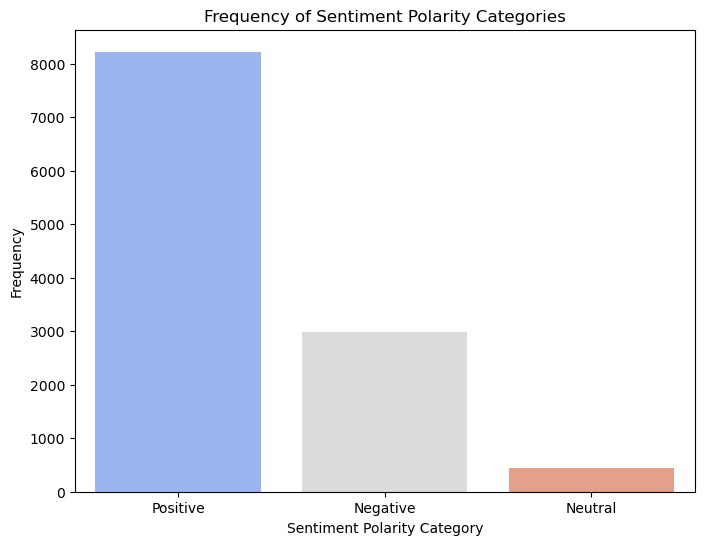

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the frequency of each sentiment polarity category
sentiment_counts = dataset_cleaned['sentiment_polarity_category'].value_counts()

# Plot the frequencies
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')
plt.title('Frequency of Sentiment Polarity Categories')
plt.xlabel('Sentiment Polarity Category')
plt.ylabel('Frequency')
plt.show()

In [40]:
# Check for duplicate rows based on all columns
duplicate_rows = dataset_cleaned.duplicated()

# Print the number of duplicate rows
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

# Optionally, display the duplicate rows
if duplicate_rows.sum() > 0:
    print("Duplicate rows:")
    print(dataset_cleaned[duplicate_rows])

# Remove duplicate rows if necessary
dataset_cleaned = dataset_cleaned.drop_duplicates()

# Confirm that duplicates are removed
print(f"Number of rows after removing duplicates: {dataset_cleaned.shape[0]}")

Number of duplicate rows: 3
Duplicate rows:
                                                   metascore  userscore  \
title                                                                     
Nintendogs + Cats: Golden Retriever & New Friends       71.0       71.0   
Pokemon Pearl Version                                   85.0       82.0   
Pokemon Sun                                             87.0       76.0   

                                                                                               genre  \
title                                                                                                  
Nintendogs + Cats: Golden Retriever & New Friends  Miscellaneous, Pet, Simulation, Virtual, Virtu...   
Pokemon Pearl Version                                       Console-style RPG, Role-Playing, Trainer   
Pokemon Sun                                                                    Role-Playing, Trainer   

                                                  platforms

In [41]:
# Check for missing values in all columns
missing_values = dataset_cleaned.isnull().sum()

# Filter columns with missing values
missing_features = missing_values[missing_values > 0]

# Display results
print("Features with missing values and their counts:")
print(missing_features)

# Optionally, show the percentage of missing values
print("\nPercentage of missing values per feature:")
print((missing_features / len(dataset_cleaned)) * 100)

Features with missing values and their counts:
max_num_players    399
dtype: int64

Percentage of missing values per feature:
max_num_players    3.421369
dtype: float64


In [42]:
# Option 1: Impute missing values in 'num_players' with a placeholder
dataset_cleaned['num_players'].fillna("Unknown", inplace=True)

# Option 2: Impute missing values in 'max_num_players' with the median
dataset_cleaned['max_num_players'].fillna(dataset_cleaned['max_num_players'].median(), inplace=True)

/var/folders/d1/myh4s_bj49bglpp9bnck2fvr0000gn/T/ipykernel_46553/502723909.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset_cleaned['num_players'].fillna("Unknown", inplace=True)
/var/folders/d1/myh4s_bj49bglpp9bnck2fvr0000gn/T/ipykernel_46553/502723909.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

In [43]:
import pandas as pd

# Display the data types for each column
print("Data Types for Each Column:")
print(dataset_cleaned.dtypes)

# Display basic structure and information about the dataset
print("\nDataset Structure:")
print(dataset_cleaned.info())

# Check the number of dimensions
print("\nNumber of Dimensions in the Dataset:")
print(dataset_cleaned.ndim)

# Optionally, display a sample of the dataset
print("\nSample of the Dataset:")
print(dataset_cleaned.head())

# If you want column-wise statistics for numerical data:
print("\nStatistics for Numerical Columns:")
print(dataset_cleaned.describe())

# If you want to check non-numeric columns:
print("\nNon-Numerical Columns:")
non_numeric_columns = dataset_cleaned.select_dtypes(exclude=['number'])
print(non_numeric_columns.head())

Data Types for Each Column:
metascore                                       float64
userscore                                       float64
genre                                            object
platforms                                        object
developer                                        object
                                                 ...   
summary_sentiment_polarity                      float64
sentiment_polarity_category                      object
summary_sentiment_polarity_category_Negative       bool
summary_sentiment_polarity_category_Neutral        bool
summary_sentiment_polarity_category_Positive       bool
Length: 4958, dtype: object

Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
Index: 11662 entries, #IDARB to xXx
Columns: 4958 entries, metascore to summary_sentiment_polarity_category_Positive
dtypes: bool(4738), category(2), float64(5), int64(205), object(8)
memory usage: 72.2+ MB
None

Number of Dimensions in the Dataset:
2

Sample of the Dat

* Check the interaction features

In [44]:
# List all column names starting with 'interaction'
interaction_columns = [col for col in dataset_cleaned.columns if col.startswith('interaction')]

print(f"Number of interaction columns: {len(interaction_columns)}")
print("Interaction Columns:")
for col in interaction_columns:
    print(col)

Number of interaction columns: 3
Interaction Columns:
interaction_platform_release_year
interaction_esrb_developer_frequency
interaction_esrb_bin


* Check the data types

In [45]:
# Check data types of all features
print("Data Types:")
print(dataset_cleaned.dtypes.value_counts())

# Find non-numerical columns
non_numerical_cols = dataset_cleaned.select_dtypes(exclude=['int64', 'float64', 'bool']).columns
print("\nNon-Numerical Columns:")
print(non_numerical_cols)

# Sample values from non-numerical columns to inspect
if not non_numerical_cols.empty:
    print("\nSample values from non-numerical columns:")
    for col in non_numerical_cols:
        print(f"\nColumn: {col}")
        print(dataset_cleaned[col].unique()[:10])  # Display a few unique values

Data Types:
bool        4738
int64        205
object         8
float64        5
category       1
category       1
Name: count, dtype: int64

Non-Numerical Columns:
Index(['genre', 'platforms', 'developer', 'esrb_rating', 'num_players',
       'summary', 'interaction_esrb_bin', 'num_players_simplified',
       'dale_chall_category', 'sentiment_polarity_category'],
      dtype='object')

Sample values from non-numerical columns:

Column: genre
['Action, General, Miscellaneous, Party / Minigame'
 '2D, Action, General, Platformer' 'Action, Miscellaneous, Music, Rhythm'
 'Compilation, Miscellaneous' 'Action RPG, Role-Playing'
 'Action, Arcade, Sci-Fi, Shooter, Third-Person'
 'Action, Arcade, Fantasy, First-Person, General, Modern, Shooter, Strategy, Turn-Based'
 'Driving, Mission-based' 'Action, Arcade, First-Person, Modern, Shooter'
 'Action, Arcade, First-Person, General, Modern, Shooter, Third-Person']

Column: platforms
['Xbox One' 'Xbox 360' 'PlayStation 3' 'PC, PlayStation 4' 'PlaySta

In [46]:
# Drop original features used for feature extraction
columns_to_drop = ['genre', 'platforms', 'developer', 'summary', 'esrb_rating', 'num_players', 'sentiment_polarity_category', 'dale_chall_category']
dataset_cleaned = dataset_cleaned.drop(columns=columns_to_drop)

In [47]:
# Check data types of all features
print("Data Types:")
print(dataset_cleaned.dtypes.value_counts())

# Find non-numerical columns
non_numerical_cols = dataset_cleaned.select_dtypes(exclude=['int64', 'float64', 'bool']).columns
print("\nNon-Numerical Columns:")
print(non_numerical_cols)

# Sample values from non-numerical columns to inspect
if not non_numerical_cols.empty:
    print("\nSample values from non-numerical columns:")
    for col in non_numerical_cols:
        print(f"\nColumn: {col}")
        print(dataset_cleaned[col].unique()[:10])  # Display a few unique values

Data Types:
bool        4738
int64        205
float64        5
category       1
object         1
Name: count, dtype: int64

Non-Numerical Columns:
Index(['interaction_esrb_bin', 'num_players_simplified'], dtype='object')

Sample values from non-numerical columns:

Column: interaction_esrb_bin
['Medium-Low', 'Medium-High', 'Low', 'High']
Categories (4, object): ['Low' < 'Medium-Low' < 'Medium-High' < 'High']

Column: num_players_simplified
['Single Player' 'Multiplayer' 'Massively Multiplayer' 'Unknown']


In [48]:
import pandas as pd

# Columns to one-hot encode
columns_to_encode = ["interaction_esrb_bin", "num_players_simplified"]

# Perform one-hot encoding with new feature names starting with original column names
dataset_cleaned = pd.get_dummies(dataset_cleaned, columns=columns_to_encode, prefix=columns_to_encode)

# Display the first few rows of the updated dataset
print(dataset_cleaned.head())

# Verify the new feature names
print("New feature names after one-hot encoding:")
print(dataset_cleaned.columns)

                             metascore  userscore  release_year  genre_2D  \
title                                                                       
#IDARB                           77.00  69.000000          2015         0   
'Splosion Man                    84.00  78.000000          2009         1   
.detuned                         46.00  37.000000          2009         0   
.hack//G.U. Last Recode          74.25  81.704082          2017         0   
.hack//G.U. vol. 1//Rebirth      69.00  80.000000          2006         0   

                             genre_2D,  genre_3D  genre_3D,  genre_4X  \
title                                                                   
#IDARB                               0         0          0         0   
'Splosion Man                        0         0          0         0   
.detuned                             0         0          0         0   
.hack//G.U. Last Recode              0         0          0         0   
.hack//G.U. vol. 1//Re

In [49]:
# List all duplicate column names with their indices
duplicate_column_details = dataset_cleaned.columns[dataset_cleaned.columns.duplicated(keep=False)]
print("Duplicate column details:")
print(duplicate_column_details)

Duplicate column details:
Index([], dtype='object')


In [50]:
import pandas as pd

def clean_feature_names(df):
    """
    Clean and deduplicate column names in a DataFrame:
    - Convert all column names to lowercase.
    - Replace special characters and spaces with underscores.
    - Ensure all column names are unique.
    """
    # Convert to lowercase and replace special characters with underscores
    cleaned_columns = df.columns.str.lower().str.replace(r'[^a-z0-9_]', '_', regex=True)
    
    # Remove leading and trailing underscores
    cleaned_columns = cleaned_columns.str.strip('_')
    
    # Ensure no duplicate column names
    deduplicated_columns = []
    seen = set()
    for col in cleaned_columns:
        new_col = col
        count = 1
        while new_col in seen:
            new_col = f"{col}_{count}"
            count += 1
        deduplicated_columns.append(new_col)
        seen.add(new_col)
    
    # Assign cleaned and deduplicated column names back to the DataFrame
    df.columns = deduplicated_columns
    return df

# Apply cleaning to your dataset
dataset_cleaned = clean_feature_names(dataset_cleaned)

# Check for duplicates again (to confirm cleaning)
if dataset_cleaned.columns.duplicated().any():
    print("Warning: There are still duplicate column names.")
else:
    print("Feature names cleaned and deduplicated successfully.")

Feature names cleaned and deduplicated successfully.


In [51]:
# List columns starting with "interaction"
interaction_columns = [col for col in dataset_cleaned.columns if col.startswith('interaction')]

# Display the columns
print("Columns starting with 'interaction':")
print(interaction_columns)

Columns starting with 'interaction':
['interaction_platform_release_year', 'interaction_esrb_developer_frequency', 'interaction_esrb_bin_low', 'interaction_esrb_bin_medium_low', 'interaction_esrb_bin_medium_high', 'interaction_esrb_bin_high']


In [52]:
import pandas as pd

# Save the cleaned dataset
dataset_cleaned.to_csv('dataset_preprocessed_v1.csv', index=True)


print("Datasets saved :")
print("- dataset_cleaned.csv")

Datasets saved :
- dataset_cleaned.csv


In [53]:
import sys
print(f"Python version: {sys.version}")

Python version: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:54:21) [Clang 16.0.6 ]


In [54]:
import numpy as np
import pandas as pd
import sklearn
import shap
import lightgbm as lgb
import xgboost as xgb
import catboost

print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"SHAP version: {shap.__version__}")
print(f"LightGBM version: {lgb.__version__}")
print(f"XGBoost version: {xgb.__version__}")
print(f"CatBoost version: {catboost.__version__}")

NumPy version: 1.26.4
Pandas version: 2.2.2
Scikit-learn version: 1.5.1
SHAP version: 0.46.0
LightGBM version: 4.5.0
XGBoost version: 2.1.2
CatBoost version: 1.2.7


In [55]:
import platform

print(f"System: {platform.system()}")
print(f"Node Name: {platform.node()}")
print(f"Release: {platform.release()}")
print(f"Version: {platform.version()}")
print(f"Machine: {platform.machine()}")
print(f"Processor: {platform.processor()}")

System: Darwin
Node Name: Mehmets-MacBook-Air.local
Release: 24.0.0
Version: Darwin Kernel Version 24.0.0: Tue Sep 24 23:36:26 PDT 2024; root:xnu-11215.1.12~1/RELEASE_ARM64_T8103
Machine: arm64
Processor: arm
